## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## 加載音頻訊號

In [2]:
data_path = '/kaggle/input/recoding-data/UAV Recordings 3s/UAV Recordings 3s'

## 音頻訊號進行MFCCs特徵提取

In [3]:
def load_data(data_dir):
    datasets = []
    labels = []
    categories = os.listdir(data_dir)
    for index, folder in enumerate(categories):
        for filename in os.listdir(data_dir+"/"+folder):
            data, sampling_rate = librosa.load(data_dir+"/"+folder+"/"+filename)
            mfccs_features = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=80)
            mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
            datasets.append(np.array(mfccs_scaled_features))
            labels.append(categories[index])
    return np.array(datasets), np.array(labels)

datasets, labels = load_data(data_path)

In [4]:
datasets = datasets.reshape(datasets.shape[0],datasets.shape[1], 1, 1).astype('float32')

labelencoder = LabelEncoder()

labelsOneHot = to_categorical(labelencoder.fit_transform(labels))

## 切分成訓練資料、測試資料，8:2的比例

In [5]:
X_train, X_test, y_train, y_test = train_test_split(datasets, labelsOneHot, test_size = 0.2, stratify = labelsOneHot, random_state = 3)

print("----------Train-------------")
print(X_train.shape)

print("----------Test--------------")
print(X_test.shape)

----------Train-------------
(1504, 80, 1, 1)
----------Test--------------
(376, 80, 1, 1)


## 類別數量

In [6]:
num_classes = len(np.unique(labels))

## 建立CNN模型

In [7]:
# 建立一個Sequential模型
model = Sequential()

# 第一層卷積層，32個3x3的過濾器
model.add(Conv2D(32, kernel_size=(5, 5), padding='same',activation='relu', input_shape=(datasets.shape[1],1,1)))

# 池化層，池化窗口大小為2x2
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# 第二層卷積層，128個3x3的過濾器
model.add(Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu'))

# 池化層，池化窗口大小為2x2
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# 第三層卷積層，256個3x3的過濾器
model.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))

# 池化層，池化窗口大小為2x2
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# Dropout層，隨機丟棄25%的神經元
model.add(Dropout(0.25))

# Flatten層，將多維輸入一維化，常用在從卷積層到全連接層的過渡
model.add(Flatten())

# 全連接層，128個輸出單元
model.add(Dense(256, activation='relu'))

# 輸出層，有5個類別，所以輸出層的輸出維度為5
model.add(Dense(num_classes, activation='softmax'))

In [8]:
# 選擇損失函數、優化方法及成效衡量方式
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 1, 32)         832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 1, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 1, 64)         51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 1, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 1, 256)        409856    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 1, 256)        0

## 訓練模型

In [9]:
train_history = model.fit(X_train, y_train, validation_split=0.2, batch_size = 100, epochs = 100, verbose=2)

Epoch 1/100
13/13 - 3s - loss: 1.5021 - accuracy: 0.3325 - val_loss: 1.3413 - val_accuracy: 0.4917 - 3s/epoch - 263ms/step
Epoch 2/100
13/13 - 1s - loss: 1.1354 - accuracy: 0.5270 - val_loss: 1.0680 - val_accuracy: 0.5316 - 1s/epoch - 107ms/step
Epoch 3/100
13/13 - 1s - loss: 0.9225 - accuracy: 0.6126 - val_loss: 0.7662 - val_accuracy: 0.6977 - 1s/epoch - 110ms/step
Epoch 4/100
13/13 - 1s - loss: 0.7647 - accuracy: 0.6791 - val_loss: 0.6748 - val_accuracy: 0.7209 - 1s/epoch - 111ms/step
Epoch 5/100
13/13 - 1s - loss: 0.6734 - accuracy: 0.7149 - val_loss: 0.6592 - val_accuracy: 0.7542 - 1s/epoch - 112ms/step
Epoch 6/100
13/13 - 1s - loss: 0.6763 - accuracy: 0.7382 - val_loss: 0.5824 - val_accuracy: 0.7508 - 1s/epoch - 106ms/step
Epoch 7/100
13/13 - 1s - loss: 0.6141 - accuracy: 0.7448 - val_loss: 0.6583 - val_accuracy: 0.7243 - 1s/epoch - 111ms/step
Epoch 8/100
13/13 - 1s - loss: 0.5931 - accuracy: 0.7681 - val_loss: 0.5702 - val_accuracy: 0.8140 - 1s/epoch - 110ms/step
Epoch 9/100
13/1

## 評估訓練結果

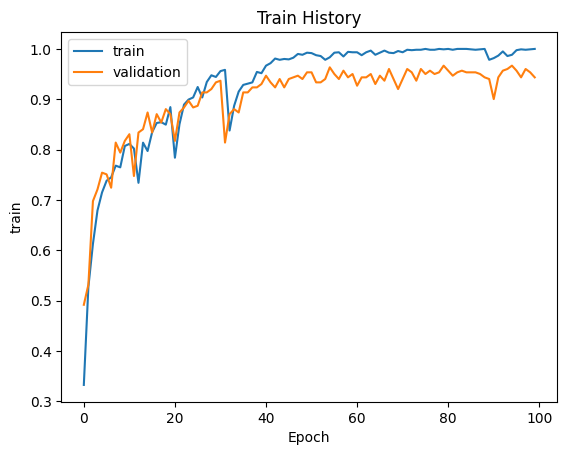

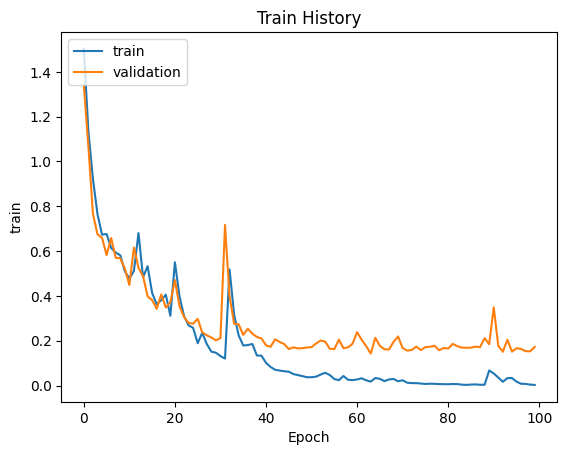

In [10]:
def show_train_history(train_history, train, validation):

    plt.plot(train_history.history[train])

    plt.plot(train_history.history[validation])

    plt.title('Train History')

    plt.ylabel('train')

    plt.xlabel('Epoch')

    plt.legend(['train', 'validation'], loc='upper left')

    plt.show()
    

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

## 使用未參與訓練的測試資料測試，模型準確率

In [11]:
scores = model.evaluate(X_test,y_test,verbose=0)

print('Accuracy = ', scores[1])

Accuracy =  0.9521276354789734


## 評估訓練結果

12/12 [==============================] - 0s 11ms/step


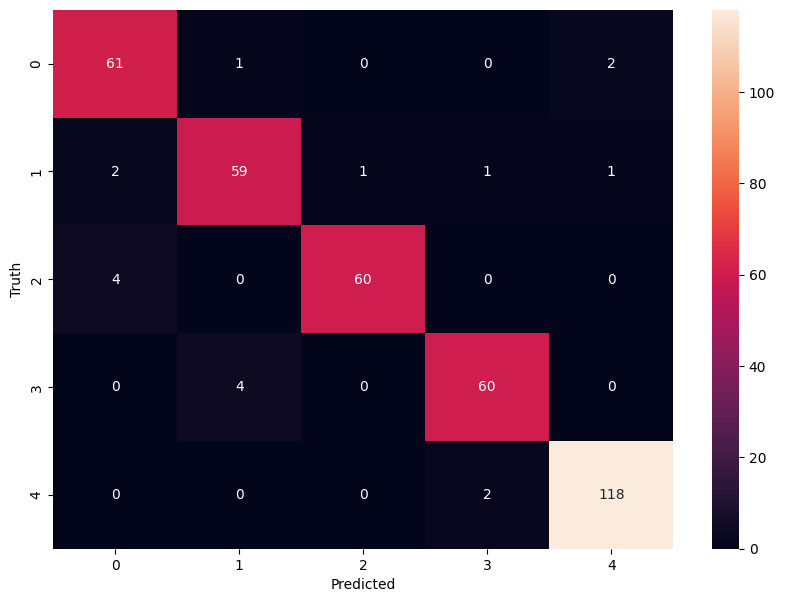

In [12]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
confusion_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()